# Bebossing detector
Dit notebook gaat in op het kunnen detecteren van bebossing vanuit satellietfoto's d.m.v. een semantic segmentation oplossing (U-Net).

# Contact
Gerrit van de Bunt (gerrit.vandebunt@student.hu.nl)\
Wail Abou (wail.abou@student.hu.nl)\
Wijnand van Dijk (wijnand.vandijk@student.hu.nl)

http://localhost:8888/notebooks/src/notebooks/unet.ipynb#Contact

# Initialisatie
Importeer alle nodige functies/classes voor onze notebook.

In [1]:
import os
import random
import tensorflow as tf
from typing import Union
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt
import random as rnd
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import packaging
import tensorflow
keras.__version__

'2.4.0'

In [2]:
# if not os.path.exists('../data'):
#     from python_scripts.onedrive_helper import *
#     oh = OneDriveHelper()
#     oh.download('data', '../')

De cel beneden zorgt ervoor dat GPU's gebruikt worden als deze aanwezig zijn en als dat mogelijk is (CUDA benodigd)

In [3]:
# gpu_amount = len(tf.config.experimental.list_physical_devices('GPU'))
# print(f'GPU acceleration enabled = {gpu_amount > 0}')

# Data
Eerst doen we een analyse op de data. Onze data is als volgt georganiseerd;
- Er zijn telkens paren van true-color-images en masks
- De masks zijn greyscaled met een waarde van 0 of 1 per pixel; 0 stelt 'geen bebossing' voor en 1 'wel bebossing'.

Standaard gebruiken we hier onze gegenereerde masks van West Bengal. Voor elke locatie in West Bengal zijn foto's en masks genomen van 3 jaren.

In [4]:
# Attributen van afbeeldingen
input_dir = "../data/Model Input Data/West_Bengal_dataset_v4/images_enhanced"
target_dir = "../data/Model Input Data/West_Bengal_dataset_v4/mask_ndvi_threshold"
img_size = (512, 512)  # 512x512
num_classes = 2  # 2 soorten labels, zoals eerder besproken
batch_size = 1  # Hoeveel afbeeldingen er in één batch moeten.

input_img_paths = sorted([
    os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir) 
    if fname.endswith(".png")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 60
../data/Model Input Data/West_Bengal_dataset_v4/images_enhanced\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2017-01-01_2018-01-01.png.png | ../data/Model Input Data/West_Bengal_dataset_v4/mask_ndvi_threshold\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2017-01-01_2018-01-01.png
../data/Model Input Data/West_Bengal_dataset_v4/images_enhanced\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2018-01-01_2019-01-01.png.png | ../data/Model Input Data/West_Bengal_dataset_v4/mask_ndvi_threshold\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2018-01-01_2019-01-01.png
../data/Model Input Data/West_Bengal_dataset_v4/images_enhanced\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2019-01-01_2020-01-01.png.png | ../data/Model Input Data/West_Bengal_dataset_v4/mask_ndvi_threshold\86.98254166666666_21.841928000000003_87.02954166666667_21.888928_2019-01-01_2020-01-01.png
../data/Model Inpu

Testsample volgt beneden

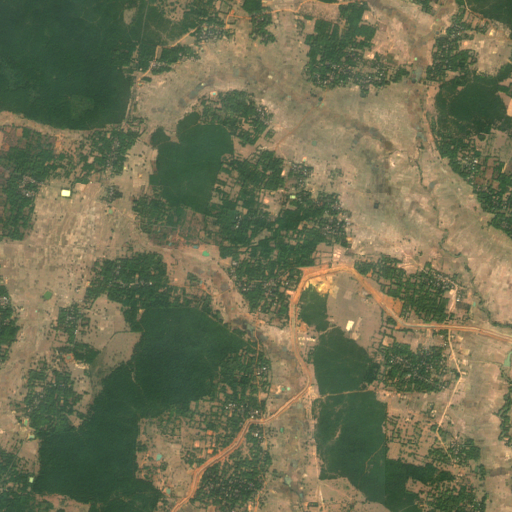

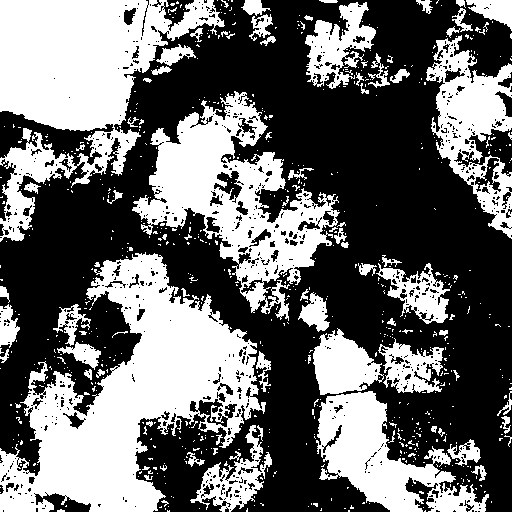

In [5]:
i = rnd.randrange(0, len(input_img_paths) - 1)

# Displays random input image
display(Image(filename=input_img_paths[i]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img)

Om ons te helpen om de data in te laden creeëren we een Class waarmee we onze data kunnen organiseren. Deze class regelt alleen niet de train/val split, dat doen we later.

In [6]:
class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            data = np.array(img)[:, :, 0]
            data = np.expand_dims(data, 2)
            y[j] = data
            y[j] = np.divide(y[j], 255)
        return x, y

# Model
Voor het model hebben we besloten om gebruik te maken van het U-Net architectuur. Na onderzoek online naar image segmentation werd beargumenteerd dat U-Net modellen beter kunnen trainen op een kleinere testset dan bijvoorbeld een variant van R-CNN. Daar tegenover stond dan weer wel dat U-Net er langer over doet om te trainen omdat het computationeel zwaar is om te trainen.

Bronnen:

-

TODO!

In [7]:
def get_model(img_size, num_classes: int):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 2,058,690
Trainable params: 2,054,914
Non-trainable params: 3,776
__________________________________________________________________________________________________


In [8]:
# Split our img paths into a training and a validation set using 80/20 split
val_samples = int(len(input_img_paths) * 0.2)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [30]:
model.layers[-1].output.shape[-1]

2

In [9]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, y_true=None, y_pred=None, num_classes=None, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred, y_true = np.array(y_pred), np.array(y_true)
        if len(y_pred.shape) >= 2:
            y_pred = tf_math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [10]:
class Precision(tf.keras.metrics.Precision):
    def __init__(self, y_true=None, y_pred=None, name='precision', dtype=None):
        super(Precision, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred, y_true = np.array(y_pred), np.array(y_true)
        if len(y_pred.shape) >= 2:
            y_pred = tf_math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [11]:
class Recall(tf.keras.metrics.Recall):
    def __init__(self, y_true=None, y_pred=None, name='recall', dtype=None):
        super(Recall, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred, y_true = np.array(y_pred), np.array(y_true)
        if len(y_pred.shape) >= 2:
            y_pred = tf_math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [19]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

model = get_model(img_size, num_classes)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2), Precision(), Recall()])
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2)])
callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 14
reshistory = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen)

Epoch 1/14
48/48 [==============================] - 62s 1s/step - loss: 1.0776 - mean_iou: 0.6033 - precision: 0.6767 - recall: 0.6579 - val_loss: 0.4612 - val_mean_iou: 0.5264 - val_precision: 0.8495 - val_recall: 0.3294
Epoch 2/14
48/48 [==============================] - 68s 1s/step - loss: 0.3173 - mean_iou: 0.7204 - precision: 0.7921 - recall: 0.7489 - val_loss: 0.5058 - val_mean_iou: 0.6779 - val_precision: 0.7509 - val_recall: 0.7060
Epoch 3/14
48/48 [==============================] - 72s 2s/step - loss: 0.2743 - mean_iou: 0.7416 - precision: 0.8122 - recall: 0.7549 - val_loss: 0.5238 - val_mean_iou: 0.6753 - val_precision: 0.7097 - val_recall: 0.7619
Epoch 4/14
48/48 [==============================] - 78s 2s/step - loss: 0.2580 - mean_iou: 0.7686 - precision: 0.8394 - recall: 0.7976 - val_loss: 0.4947 - val_mean_iou: 0.6856 - val_precision: 0.6922 - val_recall: 0.8263
Epoch 5/14
48/48 [==============================] - 75s 2s/step - loss: 0.2680 - mean_iou: 0.7547 - precision: 0

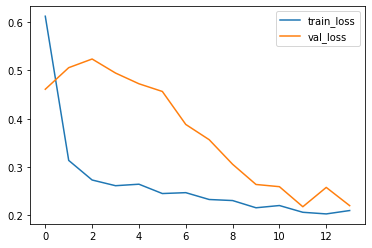

In [20]:
plt.plot(reshistory.history['loss'],label="train_loss")
plt.plot(reshistory.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

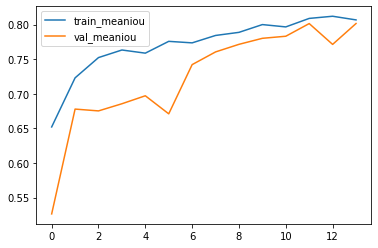

In [21]:
plt.plot(reshistory.history['mean_iou'],label="train_meaniou")
plt.plot(reshistory.history['val_mean_iou'],label="val_meaniou")
plt.legend()
plt.show()

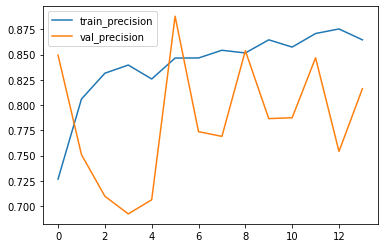

In [22]:
plt.plot(reshistory.history['precision'],label="train_precision")
plt.plot(reshistory.history['val_precision'],label="val_precision")
plt.legend()
plt.show()

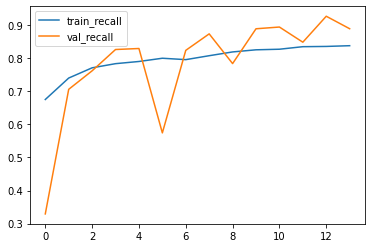

In [23]:
plt.plot(reshistory.history['recall'],label="train_recall")
plt.plot(reshistory.history['val_recall'],label="val_recall")
plt.legend()
plt.show()

In [24]:
reshistory.history['loss']

[0.6123023629188538,
 0.313836008310318,
 0.27326250076293945,
 0.2614576518535614,
 0.2645637094974518,
 0.24524140357971191,
 0.24706363677978516,
 0.2328975796699524,
 0.2307286262512207,
 0.21576285362243652,
 0.2204112559556961,
 0.20643527805805206,
 0.20305387675762177,
 0.21005140244960785]

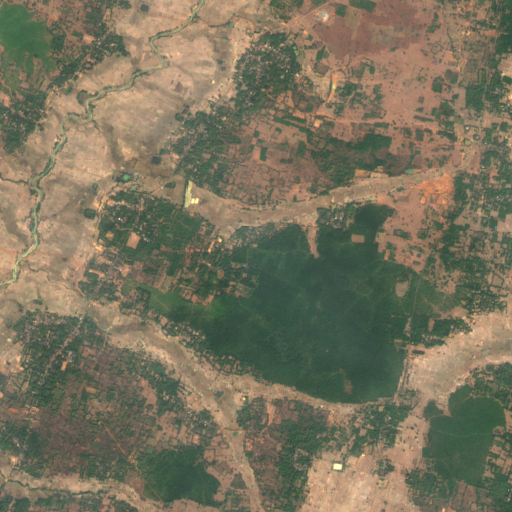

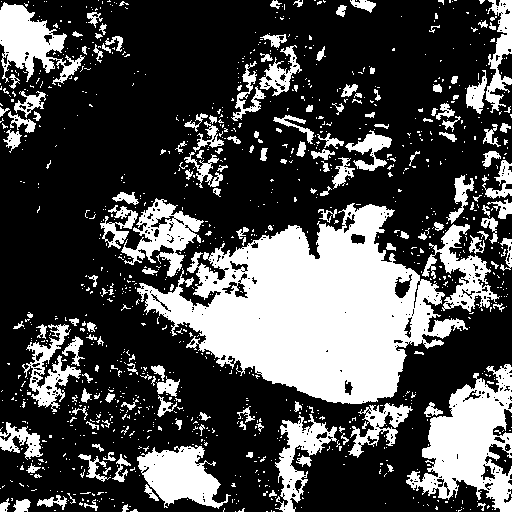

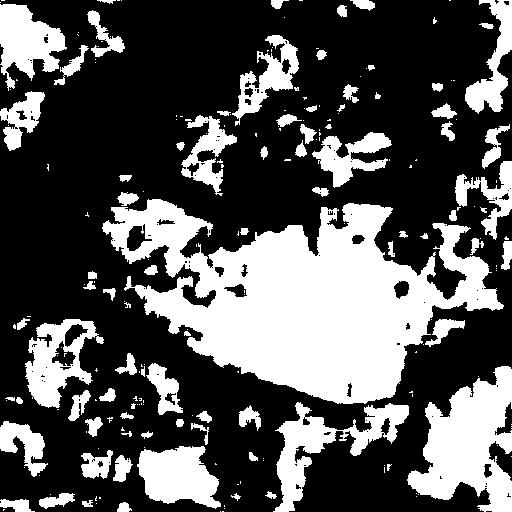

In [26]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #0
i = rnd.randrange(0, len(val_input_img_paths) - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [25]:
testsample = val_preds[i]
testsample

array([[[0.9442708 , 0.05572921],
        [0.94932956, 0.05067043],
        [0.96129566, 0.03870438],
        ...,
        [0.80896807, 0.19103196],
        [0.84575456, 0.15424545],
        [0.71188545, 0.2881146 ]],

       [[0.92581034, 0.07418963],
        [0.9865621 , 0.01343789],
        [0.98755825, 0.01244174],
        ...,
        [0.7528844 , 0.24711558],
        [0.7465308 , 0.2534692 ],
        [0.68441254, 0.31558743]],

       [[0.9348937 , 0.06510627],
        [0.98650867, 0.01349125],
        [0.9860264 , 0.01397358],
        ...,
        [0.7035227 , 0.29647735],
        [0.69630134, 0.3036987 ],
        [0.696266  , 0.303734  ]],

       ...,

       [[0.55935097, 0.44064906],
        [0.27277738, 0.7272227 ],
        [0.3155724 , 0.6844276 ],
        ...,
        [0.01759666, 0.9824033 ],
        [0.02031547, 0.9796846 ],
        [0.05722813, 0.9427719 ]],

       [[0.45395294, 0.5460471 ],
        [0.2094309 , 0.79056907],
        [0.26768237, 0.7323177 ],
        .

In [20]:
def read_model_output(data, conftreshold=None, confbasevalue=0):
    as_matrix = data.copy()
    if conftreshold is not None:
        # Get indices of highest element in probability list (base predictions)
        maxindices = np.argmax(data,axis=-1)
        # Create matrice for final predictions
        results = np.zeros(maxindices.shape)
        # Iterate over matrice
        # Assign iterator to a object so we can get it's multi_index.
        iterator = np.nditer(maxindices, flags=['multi_index']) 
        for x in iterator:
            if data[(iterator.multi_index[0], iterator.multi_index[1], x)] >= conftreshold:
                results[(iterator.multi_index[0], iterator.multi_index[1])] = maxindices[(iterator.multi_index[0], iterator.multi_index[1])]
            else:
                results[iterator.multi_index] = confbasevalue
        return results
    else:
        results = np.argmax(data,axis=-1)
    return results

In [21]:
out = read_model_output(testsample, 0.8)
display(np.unique(out))
display((out == 0).sum())
display((out == 1).sum())
out

array([0., 1.])

223659

38485

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
testsample2 = np.argmax(val_preds[i], axis=-1)
display((testsample2 == 0).sum())
display((testsample2 == 1).sum())
testsample2

177490

84654

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int64)

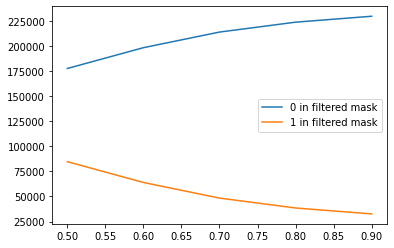

In [23]:
zeros, ones = [], []
tresholds = [0.5,0.6,0.7,0.8,0.9]
for x in tresholds:
    data = read_model_output(testsample, x)
    zeros.append((data == 0).sum())
    ones.append((data == 1).sum())
plt.plot(tresholds,zeros,label="0 in filtered mask")
plt.plot(tresholds,ones,label="1 in filtered mask")
plt.legend()
plt.show()

In [24]:
# Hyperparameter optimalisation;
# Here we define a couple of variations of the model above with slight adjustments to the hyperparameters/structure
# The performance of these models is analysed to determine the best model architecture for our current problem.

In [25]:
def alt_model_1(img_size, num_classes):
    """Alternative model getter that emphasises on additional filters."""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


def alt_model_2(img_size, num_classes):
    """Alternate model getter that emphasises on a additional up/downsampling layer"""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [26]:
# Model trialing.

models = [{"name":"baseline","model":get_model,"opt":"rmsprop"},
          {"name":"filters","model":alt_model_1,"opt":"rmsprop"},
          {"name":"up-downsampling","model":alt_model_2,"opt":"rmsprop"}]

In [27]:
def get_axes_row_col(index, cols):
    row = index // cols
    col = index % cols
    return row, col

In [28]:
history = []
for entry in models:
    ho_model = entry["model"](img_size, num_classes)
    ho_model.compile(optimizer=entry["opt"], loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2),Precision(),Recall()])
    callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation_{}.h5".format(entry["name"]), save_best_only = True)]
    outcome = ho_model.fit(train_gen, epochs=15, callbacks=callbacks, validation_data=val_gen)
    history.append(outcome.history)

Epoch 1/15
18/45 [===========>..................] - ETA: 35s - loss: 4.8331 - mean_iou: 0.4946 - precision: 0.4349 - recall: 0.5310

KeyboardInterrupt: 

In [ ]:
def plot_model_history(metric, history, models):
    ncols = len(models)
    fig, ax = plt.subplots(nrows=1, ncols=ncols, squeeze=False)
    fig.set_size_inches(18.5, 10.5)
    
    for grid_indexor in range(len(models)):
        row, col = get_axes_row_col(grid_indexor, ncols)
        # Plot desired metric
        ax[row, col].plot(history[grid_indexor][metric], label=f"{entry['name']} train_loss")
        ax[row, col].plot(history[grid_indexor][f"val_{metric}"], label=f"{entry['name']} val_loss")
    
    plt.legend()
    plt.suptitle(f'History of {metric}', fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_model_history('mean_iou', history, models)

In [ ]:
plot_model_history('loss', history, models)

In [ ]:
plot_model_history('precision', history, models)

In [ ]:
plot_model_history('recall', history, models)

In [13]:
m = Recall()
m.update_state([0, 1, 1, 1], [1, 0, 1, 1])

ValueError: in user code:

    <ipython-input-11-3e67131c43a0>:7 update_state  *
        return super().update_state(y_true, y_pred, sample_weight)
    c:\users\gvand\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\metrics.py:1406 update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    c:\users\gvand\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:354 update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    c:\users\gvand\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes () and (4,) are incompatible
